In [1]:
#importing libraries  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#loading the data. 
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [3]:
df.dtypes



Timestamp              int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

In [4]:
#Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [5]:
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.472552,4.472624,4.472552,4.472624,7.590527,34.069690,4.472579
2012-01-01,4.680778,4.680778,4.680778,4.680778,5.861697,27.856539,4.680778
2012-01-02,5.000000,5.000000,5.000000,5.000000,11.566478,57.832389,5.000000
2012-01-03,5.145917,5.145917,5.145917,5.145917,13.506125,68.725391,5.145917
2012-01-04,5.176708,5.228729,5.176708,5.228729,17.221039,91.624089,5.195443


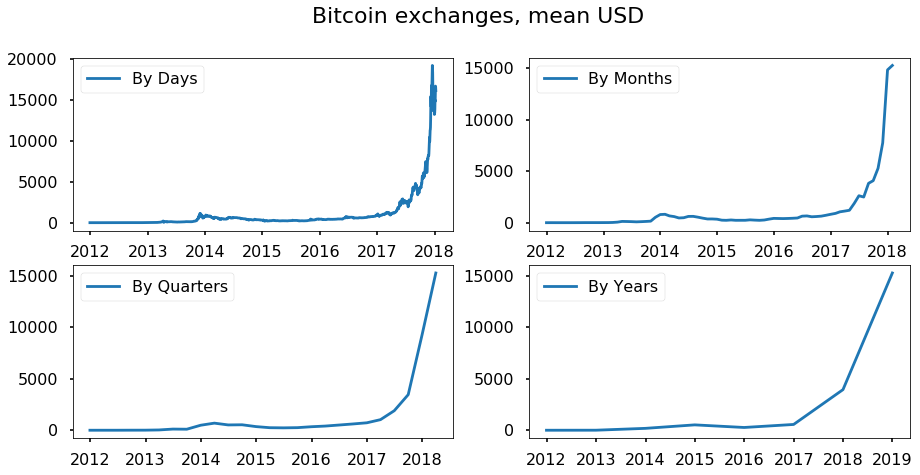

In [6]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

In [7]:
split = 50
df_train = df_month[:split] # 2012 -2016
df_test = df_month[split:len(df_month)] #2017 -8TH JAN

Dickey–Fuller test: p=0.470285


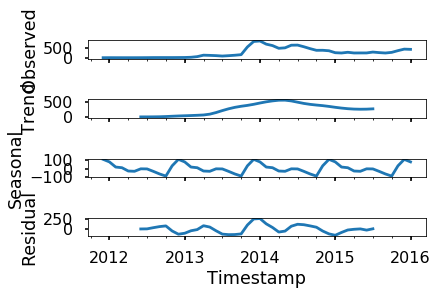

In [8]:
#Stationarity check and STL-decomposition of the series

plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_train.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Weighted_Price)[1])
plt.show()


In [9]:
# Box-Cox Transformations
df_train['Weighted_Price_box'], lmbda = stats.boxcox(df_train.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Weighted_Price)[1])

Dickey–Fuller test: p=0.470285


In [10]:
#Seasonal differentiation
df_train['prices_box_diff'] = df_train.Weighted_Price_box - df_train.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.prices_box_diff[12:])[1])


Dickey–Fuller test: p=0.104669


Dickey–Fuller test: p=0.003063


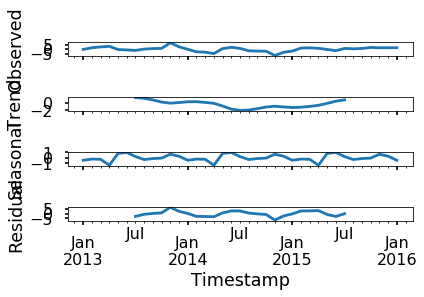

In [11]:
#as the pvalue is more than the threshold i.e 5% we conclude : The series are not stationary.

# Regular differentiation
df_train['prices_box_diff2'] = df_train.prices_box_diff - df_train.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_train.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.prices_box_diff2[13:])[1])

plt.show()


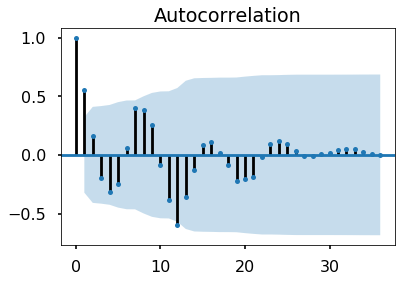

In [12]:


from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_train.prices_box_diff2[13:].values.squeeze())
pyplot.show()


In [1]:


from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_train.prices_box_diff2[13:].values.squeeze(), lags=50)
pyplot.show()


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


NameError: name 'df_train' is not defined

In [14]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 0, 2, 1)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (2, 0, 0, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 2, 0, 1)


In [1]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

NameError: name 'pd' is not defined

In [2]:
# STL-decomposition

from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf



plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

plot_acf(best_model.resid[13:].values.squeeze())

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

pyplot.show()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


NameError: name 'plt' is not defined

In [ ]:
#Prediction 
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()